In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F

from tqdm import trange

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# pip install madgrad
from madgrad import MADGRAD

# Sklearn's NMF
from sklearn.decomposition import NMF as SKNMF

In [2]:
class NMF(nn.Module):
    def __init__(self, B, N, K, act=torch.tanh):
        super(NMF, self).__init__()
        self.W = nn.Parameter(torch.distributions.Uniform(0.0, 1.0).sample((B, K))).float()
        self.H = nn.Parameter(torch.normal(0, 1, size=(K, N))).float()
        self.act = act
    def forward(self):
        if self.act is not None: return torch.matmul(self.W, self.act(self.H))
        return torch.matmul(self.W, self.H)

B = 100; N = 10; K = 2
Y = torch.rand(B, N)
nmf = NMF(B, N, K)

In [3]:
optimizer = MADGRAD(nmf.parameters(), lr=1e-2, momentum=0.99)

epochs = 20000
for i in trange(epochs):
    optimizer.zero_grad()
    
    preds = nmf()
    fro = torch.linalg.norm(preds-Y, 'fro')**2
    fro.backward()

    optimizer.step()
    
    nmf.W.data = F.relu(nmf.W.data)
    nmf.H.data = F.relu(nmf.H.data)

100%|██████████| 20000/20000 [00:05<00:00, 3786.37it/s]


In [4]:
nmf.eval()
chk_loss = ((Y-nmf())**2).mean()
chk_loss.item()

0.06197834387421608

#### Compare the performance with the Sklearn NMF function, giving close optimal solution

In [5]:
model = SKNMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(Y.detach().numpy())
H = model.components_
((W@H-Y.detach().numpy())**2).mean()

0.06197835689609433

#### Extracting Gaussian distributions example 

#### (1) Data generation

In [6]:
n_dist = 4
n_samples = 1000
time_steps = 200

dists = []
means = []
stds = []
source_contribs = np.random.uniform(0, 1, size=(n_samples, n_dist))
source_contribs = source_contribs/source_contribs.sum(axis=1).reshape(-1, 1)
source_profiles = np.zeros((n_dist, time_steps))

for i in range(n_dist):
    mean = np.random.rand()
    std = np.random.rand()
    source_profiles[i:i+1, :] = np.random.normal(mean, std, size=(1, time_steps))
    source_profiles[source_profiles<0] = 0
    
    means.append(mean)
    stds.append(std)

data = source_contribs@source_profiles

#### (2) Train the neural NMF model

In [7]:
np.sum(source_profiles<0), np.sum(source_contribs<0)

(0, 0)

In [8]:
data = torch.tensor(data).float()
nmf = NMF(n_samples, time_steps, n_dist, act=None)
optimizer = MADGRAD(nmf.parameters(), lr=1e-2, momentum=0.95)

epochs = 10000
for i in trange(epochs):
    optimizer.zero_grad()
    
    preds = nmf()
    fro = torch.linalg.norm(preds-data, 'fro')**2
    fro.backward()

    optimizer.step()
    
    nmf.W.data = F.softmax(nmf.W.data, dim=-1)
    nmf.H.data = F.relu(nmf.H.data)
    
nmf.eval()
((data-nmf())**2).mean()

100%|██████████| 10000/10000 [00:12<00:00, 812.71it/s]


tensor(1.2518e-07, grad_fn=<MeanBackward0>)

#### (3) Train Sklearn's NMF model

In [9]:
# data = data.detach().numpy()
# model = SKNMF(n_components=n_dist, init='random', random_state=0)
# W = model.fit_transform(data)
# H = model.components_
# ((W@H-data)**2).mean()

#### (4) Check the learned distributions

In [10]:
# plt_data = pd.DataFrame({'g0':H[0, :], 'g1':H[1, :], 'g2':H[2, :], 'g3':H[3, :]})
# sns.kdeplot(data=plt_data)
# plt.show()

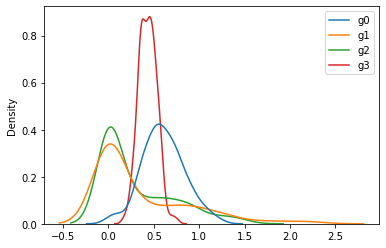

In [11]:
plt_data = pd.DataFrame({'g0':source_profiles[0, :], 'g1':source_profiles[1, :], 'g2':source_profiles[2, :], 'g3':source_profiles[3, :]})
sns.kdeplot(data=plt_data)
plt.show()

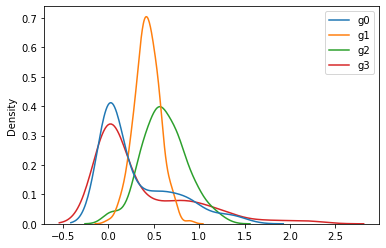

In [12]:
nmf_H = nmf.H.detach().numpy()
plt_data = pd.DataFrame({'g0':nmf_H[0, :], 'g1':nmf_H[1, :], 'g2':nmf_H[2, :], 'g3':nmf_H[3, :]})
sns.kdeplot(data=plt_data)
plt.show()

In [13]:
source_profiles.mean(axis=1), source_profiles.std(axis=1)

(array([0.60467658, 0.35093847, 0.3028073 , 0.4330821 ]),
 array([0.23248526, 0.51975452, 0.39791828, 0.09821334]))

In [14]:
nmf_H.mean(axis=1), nmf_H.std(axis=1)

(array([0.30321258, 0.42639947, 0.6120168 , 0.3512951 ], dtype=float32),
 array([0.39782694, 0.14055732, 0.2487584 , 0.5199524 ], dtype=float32))